In [1]:
import time

from vivarium.experimental.environments.braitenberg.simple import BraitenbergEnv
from vivarium.experimental.environments.braitenberg.render import render, render_history

2024-06-25 12:23:38.764571: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Init and launch a simulation

In [2]:
env = BraitenbergEnv()
state = env.init_state()

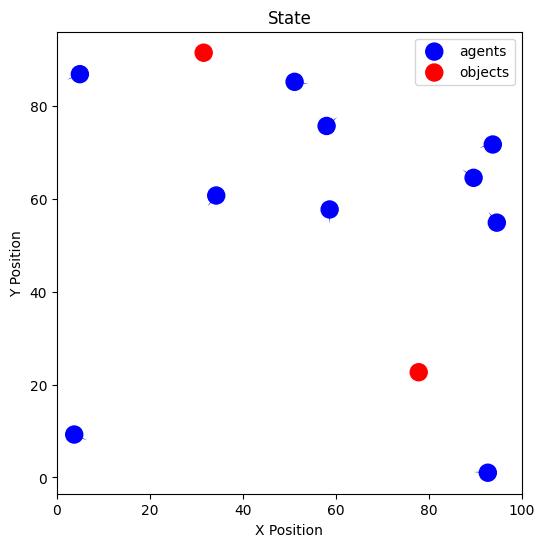

In [3]:
render(state)

In [4]:
n_steps = 1000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

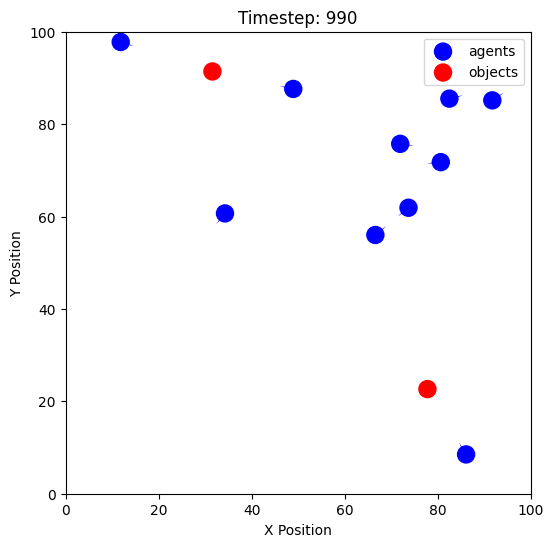

In [5]:
render_history(hist, skip_frames=10)

## Scale the size of the simulation

Launch a simulation with a bigger box size, as well as more agents and objects.

In [6]:
env = BraitenbergEnv(
    box_size=1000,
    max_agents=100,
    max_objects=50,
    existing_agents=90,
    existing_objects=30,
    prox_dist_max=100
) 
 
state = env.init_state()  

In [7]:

n_steps = 20_000

hist = []

start = time.perf_counter()
for i in range(n_steps):
    state = env.step(state) 
    hist.append(state)
end = time.perf_counter()

w_rebuilding_time = end - start
print(f"Simulation ran in {w_rebuilding_time} for {n_steps} timesteps")

Simulation ran in 9.386761042999751 for 20000 timesteps


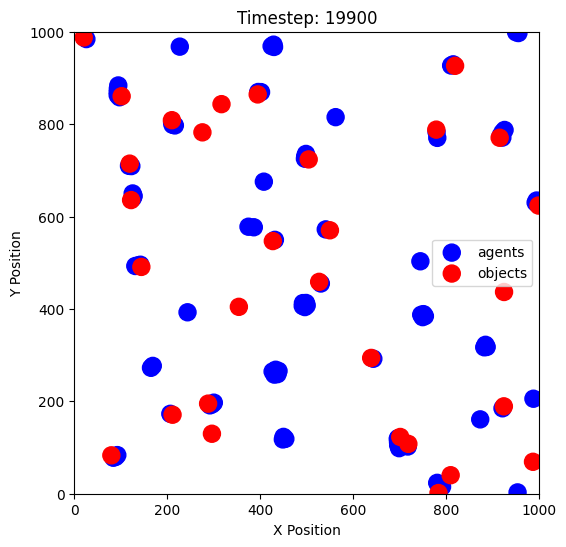

In [8]:
render_history(hist, skip_frames=100)
# (Need to update the rendering of the env because the sizes aren't accurate)

## Test neighbors rebuilding time

In the last run we see that there is a rebuilding of neighbors. To test (really roughly) how long it took, we just reduce the prox_dist_max of agents (set it to 10 which is really small). This way the original neighbor lists are the same, and because most of the agents will remain static and there won't be neighbor buffer overflow. 

In [9]:
env = BraitenbergEnv(box_size=1000,
                     max_agents=100,
                     max_objects=50,
                     existing_agents=90,
                     existing_objects=30,
                     prox_dist_max=10) 
 
state = env.init_state()  

hist = []

start = time.perf_counter()
for i in range(n_steps):
    state = env.step(state) 
    hist.append(state)
end = time.perf_counter()

wo_rebuilding_time = end - start
print(f"Simulation ran in {wo_rebuilding_time} for {n_steps} timesteps")

Simulation ran in 8.71202237000034 for 20000 timesteps


# Use manual mode

In [10]:
import jax.numpy as jnp
from vivarium.experimental.environments.braitenberg.simple import Behaviors

In [11]:
env = BraitenbergEnv()
state = env.init_state()

We will set the behavior of our first 5 agents to manual. It means their motor values will stay the same regardless of their proximeter activations and params. To better dinstinguish them from other vehicles, we will set their color to green and their motors to 1 (they will go forward).

In [12]:
behaviors = state.agents.behavior.at[0:5].set(Behaviors.MANUAL.value)
colors = state.agents.color.at[0:5].set(jnp.array([0., 1., 0.]))
motors = state.agents.motor.at[0:5].set(jnp.array([1., 1.]))

agents = state.agents.replace(behavior=behaviors, color=colors, motor=motors)
state = state.replace(agents=agents)

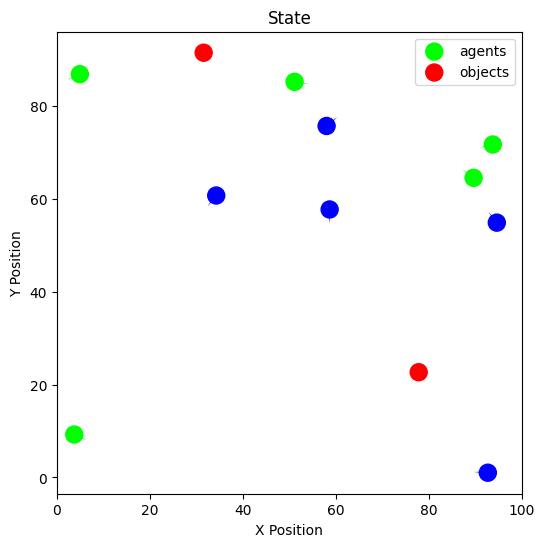

In [13]:
render(state)

In [14]:
n_steps = 10_000
hist = []

for i in range(n_steps):
    old_motors = state.agents.motor
    state = env.step(state)
    new_motors = state.agents.motor
    hist.append(state)

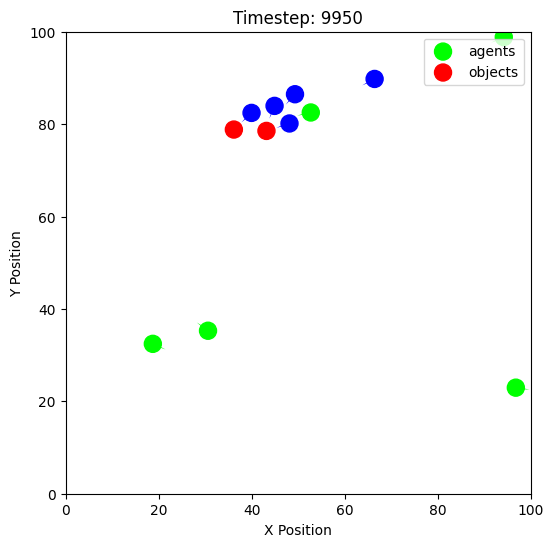

In [15]:
render_history(hist, skip_frames=50)